In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('bike_rental_hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


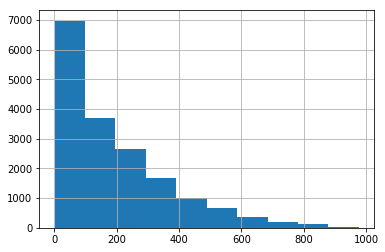

In [3]:
df.cnt.hist()

In [4]:
df.corr().cnt

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [5]:
def assign_label(num):
    if 6 <= num < 12:
        return 1
    elif 12 <= num < 18:
        return 2
    elif 18 <= num < 24:
        return 3
    else:
        return 4
df['time_label'] = df.hr.apply(assign_label)


i'm choosing mean squared error as an error metric for predicting total rental count to capture deviance from the real value while especially penalizing large deviances

In [6]:
train = df.sample(frac=.8)

In [7]:
test = df.loc[~df.index.isin(train.index)]

# linear regression

In [8]:
from sklearn.linear_model import LinearRegression

cols0 = df.columns.drop(['casual','registered','dteday','cnt'])
cols0

Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'time_label'],
      dtype='object')

In [9]:
lr = LinearRegression()
lr.fit(train[cols0], train.cnt)
preds = lr.predict(test[cols0])

In [10]:
mse = np.mean((test.cnt - preds) ** 2)
mse

17111.13583883807

the histogram revealed a right skewed distribution of cnt values. these high values could be poorly predicted in our model, and the resulting error inputs could be inflating our mse.

In [11]:
cols1 = df.columns.drop(['casual','registered','dteday','cnt','instant','hr'])
cols1

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label'],
      dtype='object')

In [12]:
lr = LinearRegression()
lr.fit(train[cols1], train.cnt)
preds = lr.predict(test[cols1])
mse = np.mean((test.cnt - preds) ** 2)
mse

18835.064541920892

suprisingly, deleting the redundant 'hr' and 'instant' columns did not decrease the error of our model.

# decision trees

In [13]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=1)
dtr.fit(train[cols0], train.cnt)
preds = dtr.predict(test[cols0])
mse = np.mean((preds - test.cnt) ** 2)
mse

3103.077675489068

our first decision tree (using the first column set) produced a dramatically lower error metric

In [14]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=1)
dtr.fit(train[cols1], train.cnt)
preds = dtr.predict(test[cols1])
mse = np.mean((preds - test.cnt) ** 2)
mse

21607.87273342603

our second decision tree (using the second column set) again produced a higher error metric. clearly, one of the columns that i removed to produce this set (instant or hr) has greater value as a feature than i anticipated

In [15]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_leaf=2, random_state=1)
dtr.fit(train[cols0], train.cnt)
preds = dtr.predict(test[cols0])
mse = np.mean((preds - test.cnt) ** 2)
mse

2785.3164556962015

instantiating the model with the minimum samples per leaf parameter set to two resulted in a nice reduction in error

In [16]:
dtr = DecisionTreeRegressor(max_depth=5, random_state=1)
dtr.fit(train[cols0], train.cnt)
preds = dtr.predict(test[cols0])
mse = np.mean((preds - test.cnt) ** 2)
mse

11809.262841720067

instantiating the model with a max depth of 5 severely reduced the effectiveness of our model here

In [17]:
dtr = DecisionTreeRegressor(min_samples_split=4, random_state=1)
dtr.fit(train[cols0], train.cnt)
preds = dtr.predict(test[cols0])
mse = np.mean((preds - test.cnt) ** 2)
mse

2858.792601649407

using this parameter resulted in a slightly better model than the vanilla model, but not as a good of a model as the second model

# random forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
rfr = RandomForestRegressor(random_state=1)
rfr.fit(train[cols0], train.cnt)
preds = rfr.predict(test[cols0])
mse0 = np.mean((preds - test.cnt) ** 2)
mse0

1977.9591599539713

our first random forest created our best model yet!

In [26]:
rfr = RandomForestRegressor(min_samples_leaf=2, random_state=1)
rfr.fit(train[cols0], train.cnt)
preds = rfr.predict(test[cols0])
mse1 = np.mean((preds - test.cnt) ** 2)
mse1

1952.784936087002

adding this parameter was negligible...

In [27]:
rmse = mse0 ** .5
rmse

44.47425277566753

In [28]:
df.cnt.describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

our best random forest regressor produced a mse of 1877 bikes squared, or, more intuitively, a rmse of 43 bikes. this is acceptable considering that the cnt column ranges from 1 to 977 with a std of 181. 